Transformer:
- Tính PositionalEmbedding (input -> cho trước Embed -> chỉ tính Positional và cộng vô Embed)
- Tính Giá trị của các Vector QKV sau khi thêm Positional và qua lớp linear (cho trước giá trị trọng số Linear)
- Tính Ma trận QK (dựa vào câu trước tính tiếp)
- Tính Ma trận giá trị Attention có mask (dựa vào kq câu trước tính Softmax(Mask(QK)).V)
- Tính Residual và Norm cho các ma trận QKV (cộng giá trị ban đầu kq câu vừa rồi và tính layer norm)


In [1]:
import os
import copy
import math
import time
import torch
import pandas as pd
import torch.nn as nn

from torch.nn.functional import log_softmax, pad

# Câu 1: Các giá trị thiếu (các ô ký hiệu là "**$?$**") trong hình lần lượt ("$?_1$", "$?_2$") là:
*(Chỉ kết quả cuối cùng được làm tròn đến chữ số thập phân thứ nhất)*

###A. $1.9, 2.0$

B. $1.9, 0.8$

C. $0.8, 2.0$

D. $0.3, 0.8$

**(Đáp án đúng là đáp án có kích thước lớn hơn so với còn lại)**

*Dưới đây là kết quả sau khi tính toán bằng code:*

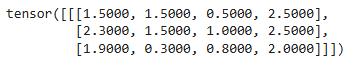

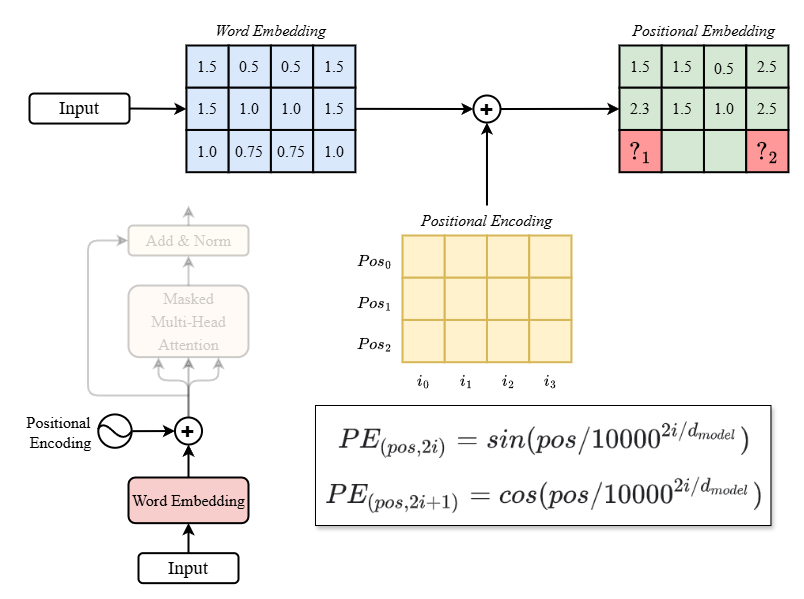

In [3]:
import math

In [6]:
1.0 + math.cos(2 / 1e4 ** (2 / 3))

1.9999907168366957

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function with decorated printing"

    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()

        print("Step 1: Initializing a zero tensor for positional encoding (pe)")
        pe = torch.zeros(max_len, d_model)
        print(pe)
        print("-" * 50)

        print("Step 2: Creating position indices")
        position = torch.arange(0, max_len).unsqueeze(1)
        print(position)
        print("-" * 50)

        print("Step 3: Calculating div_term (divisor term for encoding)")
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        # )
        div_term = 1/(10000**(torch.arange(0, d_model, 2)/d_model))
        print(div_term)
        print("-" * 50)

        print("Step 4: Applying sine and cosine functions to generate positional encodings")
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        print(pe)
        print("-" * 50)

        print("Step 5: Adding a batch dimension to positional encoding")
        pe = pe.unsqueeze(0)
        self.pe = pe
        print(pe)
        print("-" * 50)

    def forward(self, x):
        result = x + self.pe[:, : x.size(1)]
        print("Step 6: Add Positional Encodings to the Input Embeddings", result.shape)
        print(result)
        print("-" * 50)
        return result


In [ ]:
d_model = 4
max_len = 3

# (Batch size = 1, max_len, d_model)
input = torch.tensor([
    [[1.5, 0.5, 0.5, 1.5],  # <- Pos 0
     [1.5, 1.0, 1.0, 1.5],  # <- Pos 1
     [1.0, 0.75, 0.75, 1.0]],  # <- Pos 2
     # i0  i1   i2   i3
])

pos_encoding = PositionalEncoding(d_model=d_model, max_len=max_len)
pos_emb = pos_encoding(input)

Step 1: Initializing a zero tensor for positional encoding (pe)
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
--------------------------------------------------
Step 2: Creating position indices
tensor([[0],
        [1],
        [2]])
--------------------------------------------------
Step 3: Calculating div_term (divisor term for encoding)
tensor([1.0000, 0.0100])
--------------------------------------------------
Step 4: Applying sine and cosine functions to generate positional encodings
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998]])
--------------------------------------------------
Step 5: Adding a batch dimension to positional encoding
tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998]]])
--------------------------------------------------
Step 6: Add Positional Encodings

In [ ]:
pos_emb = torch.floor(pos_emb * 10 + 0.5) / 10
pos_emb

tensor([[[1.5000, 1.5000, 0.5000, 2.5000],
         [2.3000, 1.5000, 1.0000, 2.5000],
         [1.9000, 0.3000, 0.8000, 2.0000]]])

# Câu 2, 3, 4

## Câu 2: Các giá trị thiếu (các ô ký hiệu là "$?$") trong hình lần lượt ("$?_1$", "$?_2$", "**$?_3$**") là:
*(Chỉ kết quả cuối cùng được làm tròn đến chữ số thập phân thứ nhất)*

A. $3.4, 2.9, 1.8$

B. $2.9, 1.8, 3.4$

### C. $2.9, 3.4, 1.8$

D. $1.8, 3.4, 2.9$

**(Đáp án đúng là đáp án có kích thước lớn hơn so với còn lại)**

*Dưới đây là kết quả sau khi tính toán bằng code:*

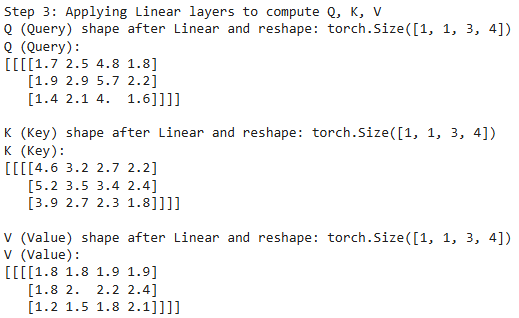

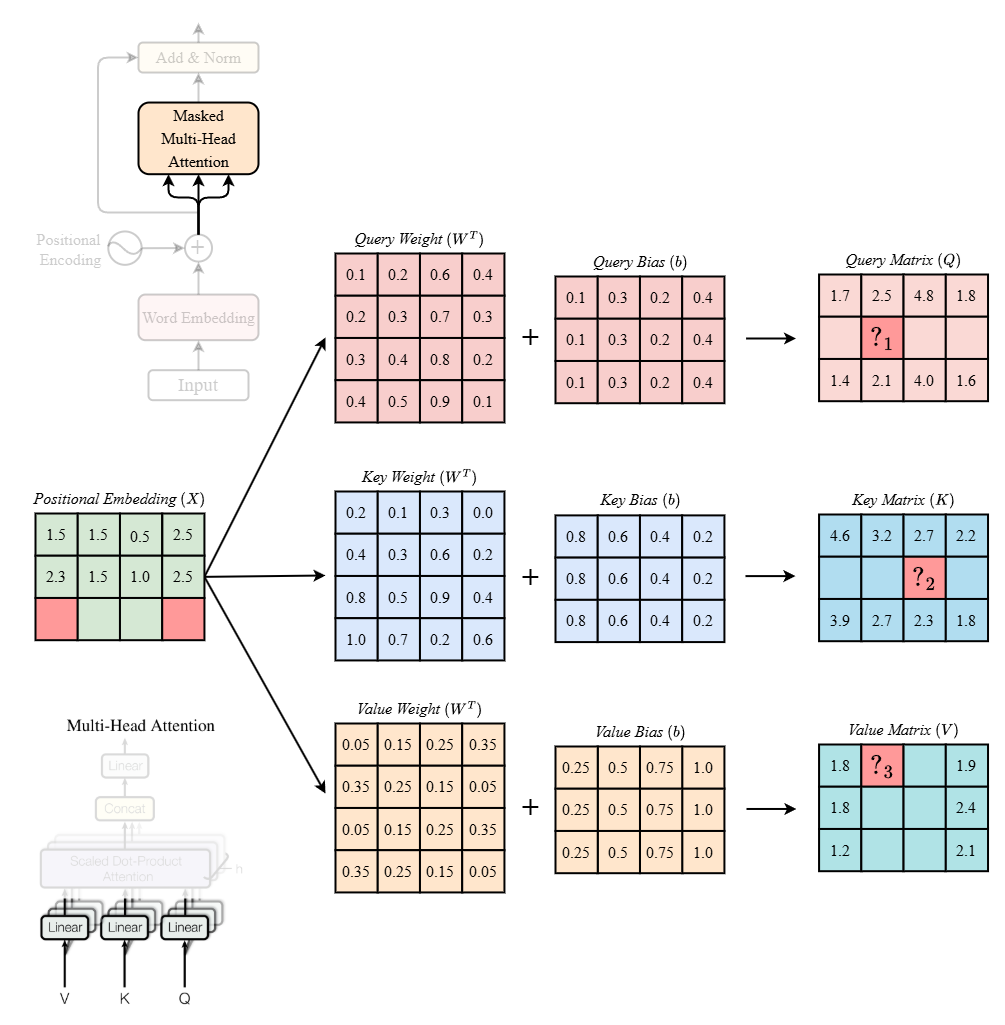

## Câu 3: Sử dụng kết quả từ câu trước, tính các giá trị thiếu (các giá trị "$?$") trong hình lần lượt ("$?_1$", "$?_2$") là:
*(Chỉ kết quả cuối cùng được làm tròn đến chữ số thập phân thứ nhất)*

A. $16.4, 13.7$

B. $13.8, 13.7$

C. $16.4, 11.6$

### D. $13.8, 11.6$

**(Đáp án đúng là đáp án có kích thước lớn hơn so với còn lại)**

*Dưới đây là kết quả sau khi tính toán bằng code:*

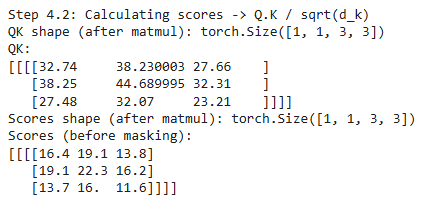

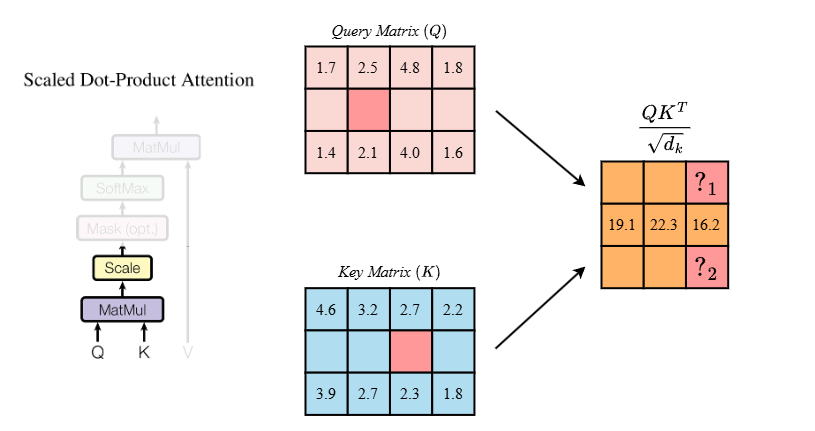

## Câu 4: Sử dụng kết quả từ câu trước, tính các giá trị thiếu (các giá trị "$?$") trong hình lần lượt ("$?_1$", "$?_2$") là:
*(Chỉ kết quả cuối cùng được làm tròn đến chữ số thập phân thứ nhất)*

A. $1.8, 1.8$

B. $2.0, 2.4$

C. $1.6, 1.8$

### D. $1.8, 2.4$

**(Đáp án đúng là đáp án có kích thước lớn hơn so với còn lại)**

*Dưới đây là kết quả sau khi tính toán bằng code:*

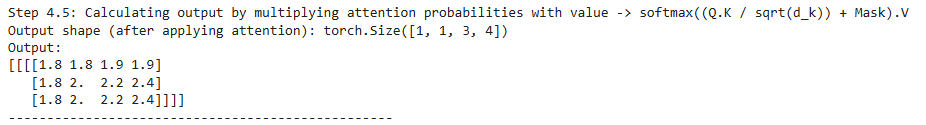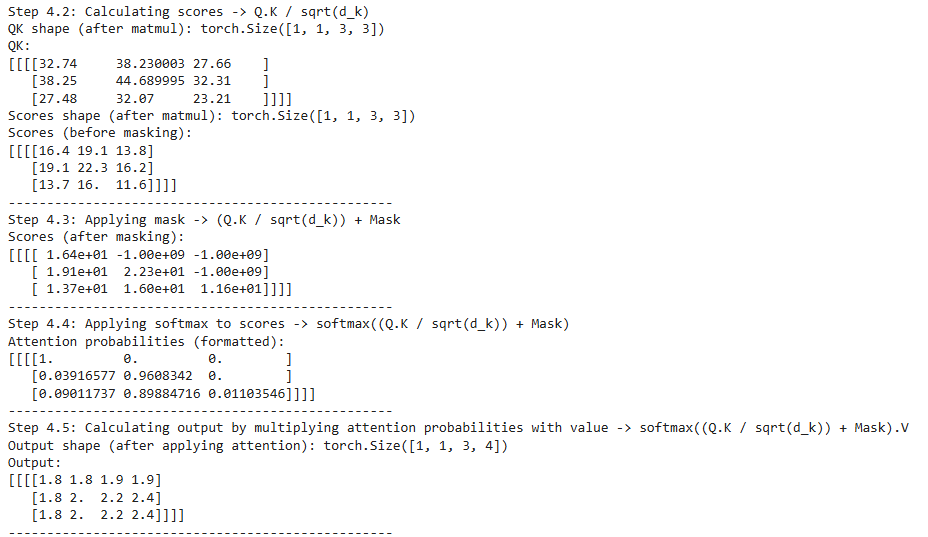

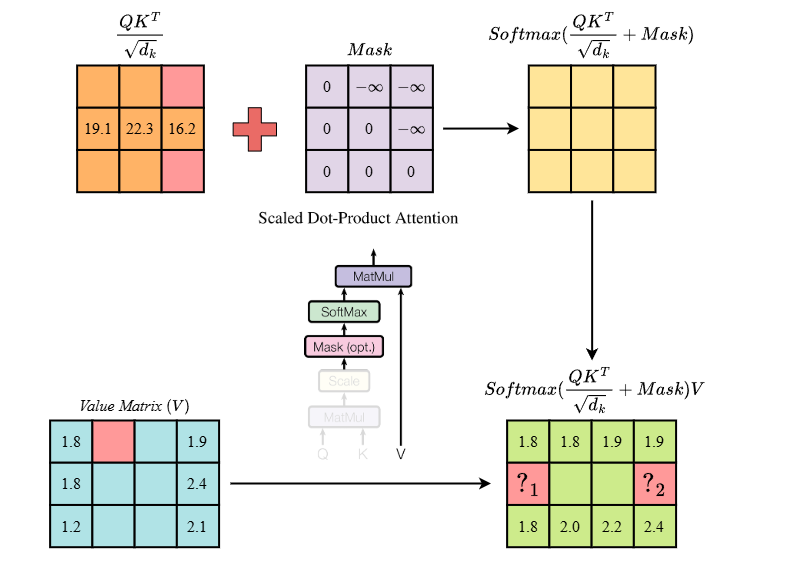

In [ ]:
def attention(query, key, value, mask=None):
    "Compute Scaled Dot Product Attention"

    print("Step 4.1: Extracting dimensions of query")
    d_k = query.size(-1)
    print(f"d_k (dimension of query): {d_k}")
    print(f"Query shape: {query.shape}")
    print(f"Key shape: {key.shape}")
    print(f"Value shape: {value.shape}")
    print("--------------------------------------------------")

    print("Step 4.2: Calculating scores -> Q.K / sqrt(d_k)")
    qk = torch.matmul(query, key.transpose(-2, -1))
    print(f"QK shape (after matmul): {qk.shape}")
    print(f"QK:\n{qk.cpu().detach().numpy()}")

    scores = qk / math.sqrt(d_k)
    scores = torch.floor(scores * 10 + 0.5) / 10
    print(f"Scores shape (after matmul): {scores.shape}")
    print(f"Scores (before masking):\n{scores.cpu().detach().numpy()}")
    print("--------------------------------------------------")

    if mask is not None:
        print("Step 4.3: Applying mask -> (Q.K / sqrt(d_k)) + Mask")
        scores = scores.masked_fill(mask == 0, -1e9)
        print(f"Scores (after masking):\n{scores.cpu().detach().numpy()}")
        print("--------------------------------------------------")

    print("Step 4.4: Applying softmax to scores -> softmax((Q.K / sqrt(d_k)) + Mask)")
    p_attn = scores.softmax(dim=-1)
    print(f"Attention probabilities (formatted):\n{p_attn.cpu().detach().numpy()}")
    print("--------------------------------------------------")

    print("Step 4.5: Calculating output by multiplying attention probabilities with value -> softmax((Q.K / sqrt(d_k)) + Mask).V")
    output = torch.matmul(p_attn, value)  # Attention weight Matrix * V
    output = torch.floor(output * 10 + 0.5) / 10
    print(f"Output shape (after applying attention): {output.shape}")
    print(f"Output:\n{output.cpu().detach().numpy()}")
    print("--------------------------------------------------")

    return output, p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model):
        "Take in model size and number of heads"

        super(MultiHeadedAttention, self).__init__()

        print("Step 1: Initializing dimensions and layers")
        self.d_k = d_model // h
        self.d_v = d_model // h

        self.h = h
        self.attn = None

        print(f"d_k (dimension per head): {self.d_k}")
        print(f"d_v (dimension per head): {self.d_v}")
        print("--------------------------------------------------")

        print("Step 2: Initializing Linear layers for Q, K, V")
        self.W_Q = nn.Linear(d_model, self.d_k)
        self.W_K = nn.Linear(d_model, self.d_k)
        self.W_V = nn.Linear(d_model, self.d_v)
        print(f"W_Q weights initialized: {self.W_Q.weight.shape}")
        print(f"W_K weights initialized: {self.W_K.weight.shape}")
        print(f"W_V weights initialized: {self.W_V.weight.shape}")
        print("--------------------------------------------------")

        # Set custom weights and biases for W_Q, W_K, W_V
        with torch.no_grad():
            print("Step 3: Setting custom weights and biases")
            # W_Q
            self.W_Q.weight.copy_(torch.tensor([[0.1, 0.2, 0.3, 0.4],
                                                [0.2, 0.3, 0.4, 0.5],
                                                [0.6, 0.7, 0.8, 0.9],
                                                [0.4, 0.3, 0.2, 0.1]]))
            self.W_Q.bias.copy_(torch.tensor([0.1, 0.3, 0.2, 0.4]))
            print(f"W_Q weights: \n{self.W_Q.weight.cpu().numpy()}\n")
            print(f"W_Q bias: \n{self.W_Q.bias.cpu().numpy()}\n")

            # W_K
            self.W_K.weight.copy_(torch.tensor([[0.2, 0.4, 0.8, 1.0],
                                                [0.1, 0.3, 0.5, 0.7],
                                                [0.3, 0.6, 0.9, 0.2],
                                                [0.0, 0.2, 0.4, 0.6]]))
            self.W_K.bias.copy_(torch.tensor([0.8, 0.6, 0.4, 0.2]))
            print(f"W_K weights: \n{self.W_K.weight.cpu().numpy()}\n")
            print(f"W_K bias: \n{self.W_K.bias.cpu().numpy()}\n")

            # W_V
            self.W_V.weight.copy_(torch.tensor([[0.05, 0.35, 0.05, 0.35],
                                                [0.15, 0.25, 0.15, 0.25],
                                                [0.25, 0.15, 0.25, 0.15],
                                                [0.35, 0.05, 0.35, 0.05]]))
            self.W_V.bias.copy_(torch.tensor([0.25, 0.50, 0.75, 1.0]))
            print(f"W_V weights: \n{self.W_V.weight.cpu().numpy()}\n")
            print(f"W_V bias: \n{self.W_V.bias.cpu().numpy()}\n")
            print("--------------------------------------------------")

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            print("Step 1: Adding mask for all heads")
            mask = mask.unsqueeze(1).expand(-1, self.h, -1, -1)
            print(f"Mask shape after expansion: {mask.shape}")
            print("--------------------------------------------------")

        print("Step 2: Input shapes")
        print(f"Query input shape: {query.shape}")
        print(f"Key input shape: {key.shape}")
        print(f"Value input shape: {value.shape}")
        print("--------------------------------------------------")

        print("Step 3: Applying Linear layers to compute Q, K, V")
        Q = self.W_Q(query).view(query.size(0), -1, self.h, self.d_k).transpose(1, 2)
        Q = torch.floor(Q * 10 + 0.5) / 10
        K = self.W_K(key).view(key.size(0), -1, self.h, self.d_k).transpose(1, 2)
        K = torch.floor(K * 10 + 0.5) / 10
        V = self.W_V(value).view(value.size(0), -1, self.h, self.d_v).transpose(1, 2)
        V = torch.floor(V * 10 + 0.5) / 10

        print(f"Q (Query) shape after Linear and reshape: {Q.shape}")
        print(f"Q (Query):\n{Q.cpu().detach().numpy()}\n")
        print(f"K (Key) shape after Linear and reshape: {K.shape}")
        print(f"K (Key):\n{K.cpu().detach().numpy()}\n")
        print(f"V (Value) shape after Linear and reshape: {V.shape}")
        print(f"V (Value):\n{V.cpu().detach().numpy()}\n")
        print("--------------------------------------------------")

        print("Step 4: Computing attention")
        x, self.attn = attention(Q, K, V, mask=mask)

        x = x.transpose(1, 2).contiguous().view(query.size(0), -1, self.h * self.d_v)

        print(f"Final output shape: {x.shape}")
        print(x)

        return x

In [ ]:
query = pos_emb
key = pos_emb
value = pos_emb

mask = torch.tensor([[[1, 0, 0],
                      [1, 1, 0],
                      [1, 1, 1]]])

heads = 1
multi_head_attention = MultiHeadedAttention(heads, d_model)

attention_output = multi_head_attention(query, key, value, mask)

Step 1: Initializing dimensions and layers
d_k (dimension per head): 4
d_v (dimension per head): 4
--------------------------------------------------
Step 2: Initializing Linear layers for Q, K, V
W_Q weights initialized: torch.Size([4, 4])
W_K weights initialized: torch.Size([4, 4])
W_V weights initialized: torch.Size([4, 4])
--------------------------------------------------
Step 3: Setting custom weights and biases
W_Q weights: 
[[0.1 0.2 0.3 0.4]
 [0.2 0.3 0.4 0.5]
 [0.6 0.7 0.8 0.9]
 [0.4 0.3 0.2 0.1]]

W_Q bias: 
[0.1 0.3 0.2 0.4]

W_K weights: 
[[0.2 0.4 0.8 1. ]
 [0.1 0.3 0.5 0.7]
 [0.3 0.6 0.9 0.2]
 [0.  0.2 0.4 0.6]]

W_K bias: 
[0.8 0.6 0.4 0.2]

W_V weights: 
[[0.05 0.35 0.05 0.35]
 [0.15 0.25 0.15 0.25]
 [0.25 0.15 0.25 0.15]
 [0.35 0.05 0.35 0.05]]

W_V bias: 
[0.25 0.5  0.75 1.  ]

--------------------------------------------------
Step 1: Adding mask for all heads
Mask shape after expansion: torch.Size([1, 1, 3, 3])
--------------------------------------------------
Ste

# Câu 5: Sử dụng kết quả từ câu trước, tính các giá trị thiếu (các giá trị "$?$") trong hình lần lượt ("$?_1$", "$?_2$") là:
*(Chỉ kết quả cuối cùng được làm tròn đến chữ số thập phân thứ hai)*

## A. $-0.06, 1.28$

B. $-0.06, -1.16$

C. $0.06, 1.28$

D. $0.06, -1.16$

**(Đáp án đúng là đáp án có kích thước lớn hơn so với còn lại)**

*Dưới đây là kết quả sau khi tính toán bằng code:*



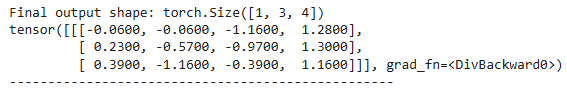

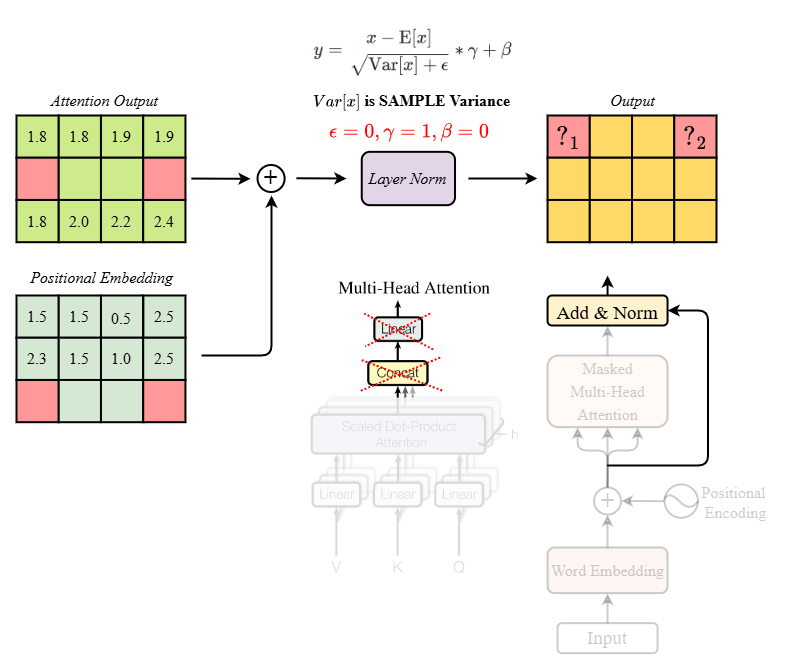

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module"

    def __init__(self, features, eps=0):
        super(LayerNorm, self).__init__()
        self.a_2 = torch.ones(features)
        self.b_2 = torch.zeros(features)
        self.eps = eps

    def forward(self, x):
        print("Step 2.1: Calculating mean and standard deviation")
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        print(f"Mean shape: {mean.shape}, Values: {mean.flatten().tolist()}")
        print(f"Standard deviation shape: {std.shape}, Values: {std.flatten().tolist()}")
        print("--------------------------------------------------")

        print("Step 2.2: Normalizing the input")
        normalized_x = self.a_2 * (x - mean) / (std + self.eps) + self.b_2
        print(f"Normalized output shape: {normalized_x.shape}")
        print("--------------------------------------------------")

        return normalized_x


class AddNorm(nn.Module):
    def __init__(self, size):
        super(AddNorm, self).__init__()
        self.norm = LayerNorm(size)

    def forward(self, x, res_x):
        print("Step 1: Adding residual connection")
        add_x = x + res_x
        print(f"After Adding shape: {add_x.shape}")
        print(add_x.detach().cpu().numpy())
        print("--------------------------------------------------\n")

        print("Step 2: Applying LayerNorm")
        norm_x = self.norm(add_x)
        # norm_x = torch.floor(norm_x * 100 + 0.5) / 100
        print(f"Final output shape: {norm_x.shape}")
        print(norm_x)
        print("--------------------------------------------------")

        return norm_x

In [ ]:
addnorm = AddNorm(d_model)

add_norm = addnorm(attention_output, pos_emb)

Step 1: Adding residual connection
After Adding shape: torch.Size([1, 3, 4])
[[[3.3       3.3       2.4       4.4      ]
  [4.1       3.5       3.2       4.9      ]
  [3.6999998 2.3       3.        4.4      ]]]
--------------------------------------------------

Step 2: Applying LayerNorm
Step 2.1: Calculating mean and standard deviation
Mean shape: torch.Size([1, 3, 1]), Values: [3.3499999046325684, 3.9250001907348633, 3.3499999046325684]
Standard deviation shape: torch.Size([1, 3, 1]), Values: [0.8185352683067322, 0.75, 0.9036961197853088]
--------------------------------------------------
Step 2.2: Normalizing the input
Normalized output shape: torch.Size([1, 3, 4])
--------------------------------------------------
Final output shape: torch.Size([1, 3, 4])
tensor([[[-0.0611, -0.0611, -1.1606,  1.2828],
         [ 0.2333, -0.5667, -0.9667,  1.3000],
         [ 0.3873, -1.1619, -0.3873,  1.1619]]])
--------------------------------------------------


In [ ]:
model = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads)

In [ ]:
Q = torch.tensor([1.7, 2.5, 4.8, 1.8])
K = torch.tensor([3.9, 2.7, 2.3, 1.8])
Q @ K.T / 2

tensor(13.8300)

: 